In [1]:
%pylab inline
#from sharpy import *
import sys
import geopandas
import shapely
sharpy = sys.path.insert(0,"/Users/Alfonso Lovati/Desktop/TESI_MAGISTRALE/sharpy/sharpy" )
sys.path.insert(0,'sharpy/*.py')

from SharadRadagrams import *
from Definitions import *
from FirstReflectionDetection import *
from Utils import *
from StructureGradient import *

from copy import deepcopy

from pathlib import Path
import fiona.crs
import logging as log
import attr, sys
from shapely.geometry import Point
import os
import numpy as np
import pandas as pd
import cv2 as cv
from osgeo import gdal
from datetime import datetime
from geopandas import GeoDataFrame

north_pole_crs = fiona.crs.from_string("+proj=stere +lat_0=90 +lon_0=0 +k=1 +x_0=0 +y_0=0 +a=3396190 +b=3376200 +units=m +no_defs ")
mars_2000_crs = fiona.crs.from_string("+proj=longlat +a=3396190 +b=3376200 +no_defs ")

mars_2000_crs_sphere = fiona.crs.from_string("+proj=longlat +a=3376200.0   +b=3376200.0 +no_defs ")
north_pole_crs_sphere = fiona.crs.from_string("+proj=stere +lat_0=90 +lon_0=0 +k=1 +x_0=0 +y_0=0 +a=3376200.0   +b=3376200.0 +units=m +no_defs ")

Populating the interactive namespace from numpy and matplotlib


In [2]:
#attempt: taking a certain number (n) of equispaziated point in the circle that limits the no-data zone.
#idea: begin with a random value and than follow in polar coordinate adding an angle of 2*pi/n
#for each point take the track that passes from it (should be the tangent line) --> n tracks equally distributed

import math

def PointInCircle(radius, N_points):
    a = random.random()
    theta = np.zeros(N_points)
    x = np.zeros(N_points)
    y = np.zeros(N_points)
    points = []
    i = 0
    while i < N_points :
        theta[i] = math.acos(a) + i*2*np.pi/N_points
        plt.polar(theta[i],radius, 'o')
        x[i] = radius*cos(theta[i])
        y[i] = radius*sin(theta[i])
        points.append(Point(x[i],y[i]))
        i +=1 
    #x= radius*np.cos(a)
    #y= radius*np.sin(a)
    return theta, x, y, points

In [16]:
regions2 = '/Users/Alfonso Lovati/Desktop/TESI_MAGISTRALE/sharpy/data/test_data/calotta.gpkg'

regions2_ = geopandas.read_file(regions2)

In [4]:
man = SharadRadagramsManager()
man.loadDatabase()
#loading the lat/long database

In [5]:
good = man.db.to_crs(regions2_.crs).intersects(regions2_.geometry[0])
#selection of the tracks that intersect the region and converting in the region sdr
print (regions2_.geometry[0])
print(type(good))

POLYGON ((-588973.6860753663 403996.1267051262, 557861.824582167 411254.5793042245, 557943.4060934539 -711569.3202501846, -9203.659143693754 -713478.9063284217, -574441.138302602 -711569.3202501847, -588973.6860753663 403996.1267051262))
<class 'pandas.core.series.Series'>


In [6]:
sel = man.db[good]
sel.set_index("track_id", inplace=True)

In [7]:
o = sel.to_crs(regions2_.crs).intersection(regions2_.geometry[0])
#cutting the tracks
# o.plot()
sel.geometry = o

C:\Users\Alfonso Lovati\Anaconda3\lib\site-packages\geopandas\geodataframe.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[geo_column_name] = level


In [9]:
radius = 154700  #better if we use the converted value of the km radius of the forbidden zone 

b = Point(0, 0).buffer(radius)

print(type(b))

<class 'shapely.geometry.polygon.Polygon'>


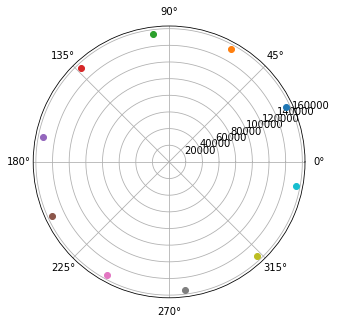

In [10]:
figure(figsize(5,5))
pointyo = PointInCircle(radius,10)[-1]

<Figure size 1080x1080 with 0 Axes>

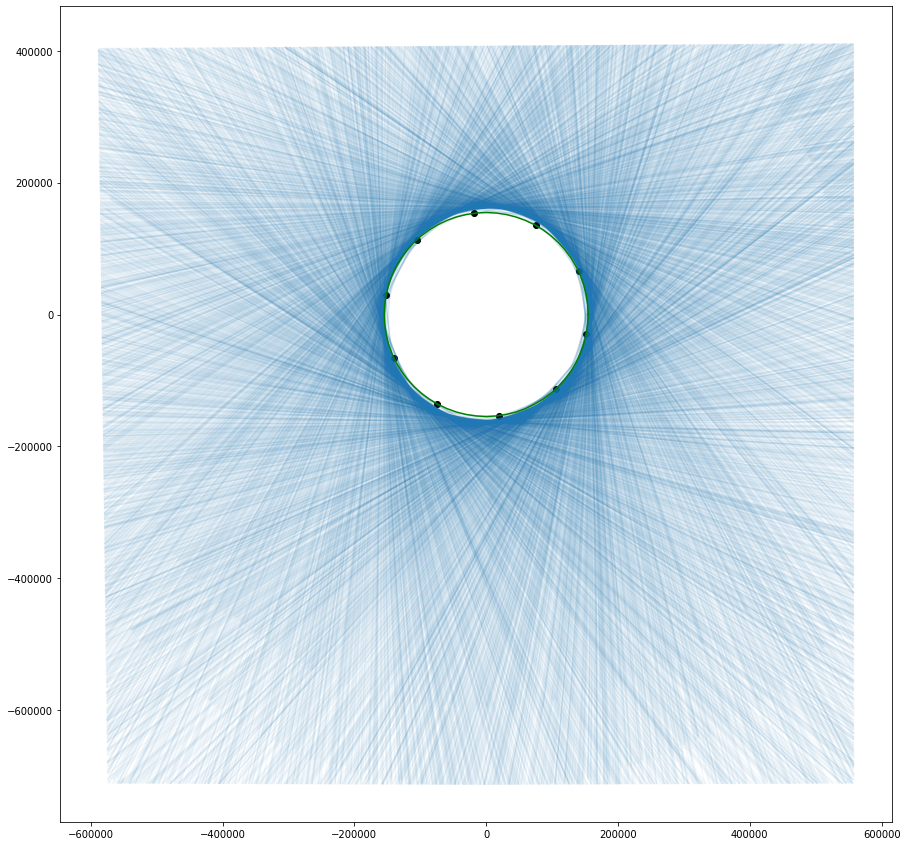

In [11]:
figure(figsize(15,15))
sel.plot(alpha=0.05)
xs = [point.x for point in pointyo]
ys = [point.y for point in pointyo]
plt.scatter(xs, ys, c='k')
plot(*b.exterior.xy,'g')

<Figure size 1440x1440 with 0 Axes>

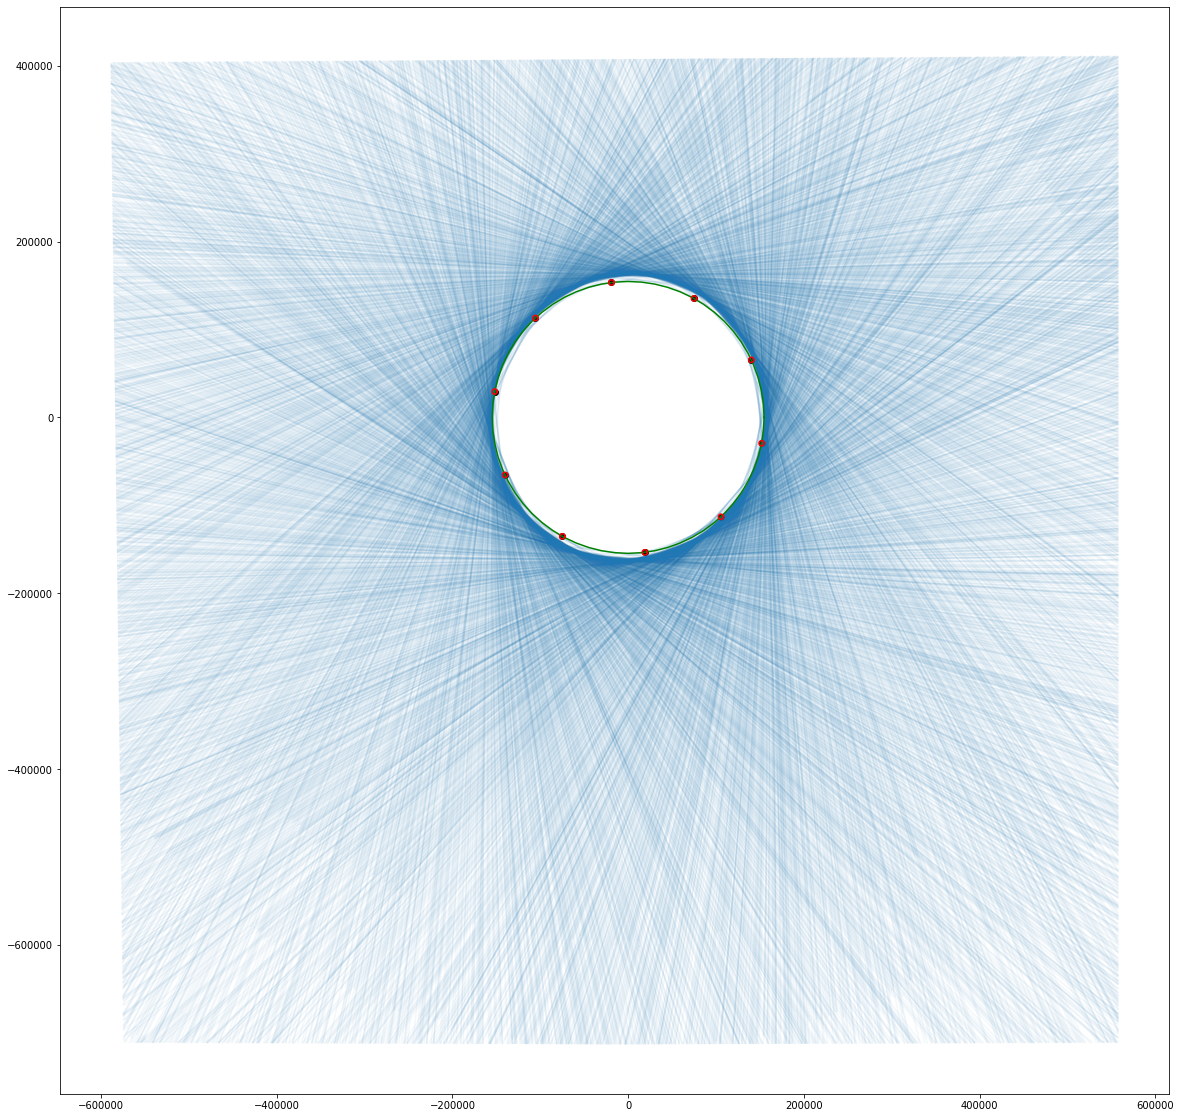

In [12]:
figure(figsize(20,20))
sel.plot(alpha=0.05)
xs = [point.x for point in pointyo]
ys = [point.y for point in pointyo]
plt.scatter(xs, ys, c='k')
plot(*b.exterior.xy,'g')

subpoligons = []
for i in range(len(pointyo)):
    subpoligons.append(pointyo[i].buffer(3000))   #radius of the sub-poligons, we can find a better value
    plot(*subpoligons[i].exterior.xy,'r')
    

In [13]:
secondsel = []
sol2 = deepcopy(subpoligons)
reference_region2 = deepcopy(regions2_)
status2 = shapely.geometry.MultiPolygon([deepcopy(regions2_.geometry[0])])

for i in range(len(subpoligons)):
    good2 = man.db.to_crs(regions2_.crs).intersects(subpoligons[i])
    sel2 = man.db[good2]
    sel2.set_index("track_id", inplace=True)
    secondsel.append(sel2)

In [14]:
print(secondsel)

[                                                   geometry
track_id                                                   
01221901  LINESTRING (186.373 73.036, 186.045 73.558, 18...
01824501  LINESTRING (191.340 69.918, 191.094 70.433, 19...
05624801  LINESTRING (124.370 87.318, 113.103 87.360, 10...
04417001  LINESTRING (178.252 74.903, 177.858 75.424, 17...
02243801  LINESTRING (196.222 69.933, 195.974 70.449, 19...
04017401  LINESTRING (124.600 87.334, 113.266 87.383, 10...
04010801  LINESTRING (126.315 87.332, 115.008 87.380, 10...
01980101  LINESTRING (190.465 69.913, 190.216 70.436, 18...
01982701  LINESTRING (200.588 69.931, 200.336 70.453, 20...
01232402  LINESTRING (199.770 72.960, 199.441 73.480, 19...
04136101  LINESTRING (188.755 74.884, 188.348 75.405, 18...
01406501  LINESTRING (189.232 69.900, 188.984 70.423, 18...
01613502  LINESTRING (197.603 69.903, 197.357 70.418, 19...
01947101  LINESTRING (197.946 72.925, 197.617 73.446, 19...
04543502  LINESTRING (207.418 74.928, 2

['01605601', '04254601', '04474702', '01700101', '04441401', '01399202', '04376601', '04263001', '01752201', '04136201']


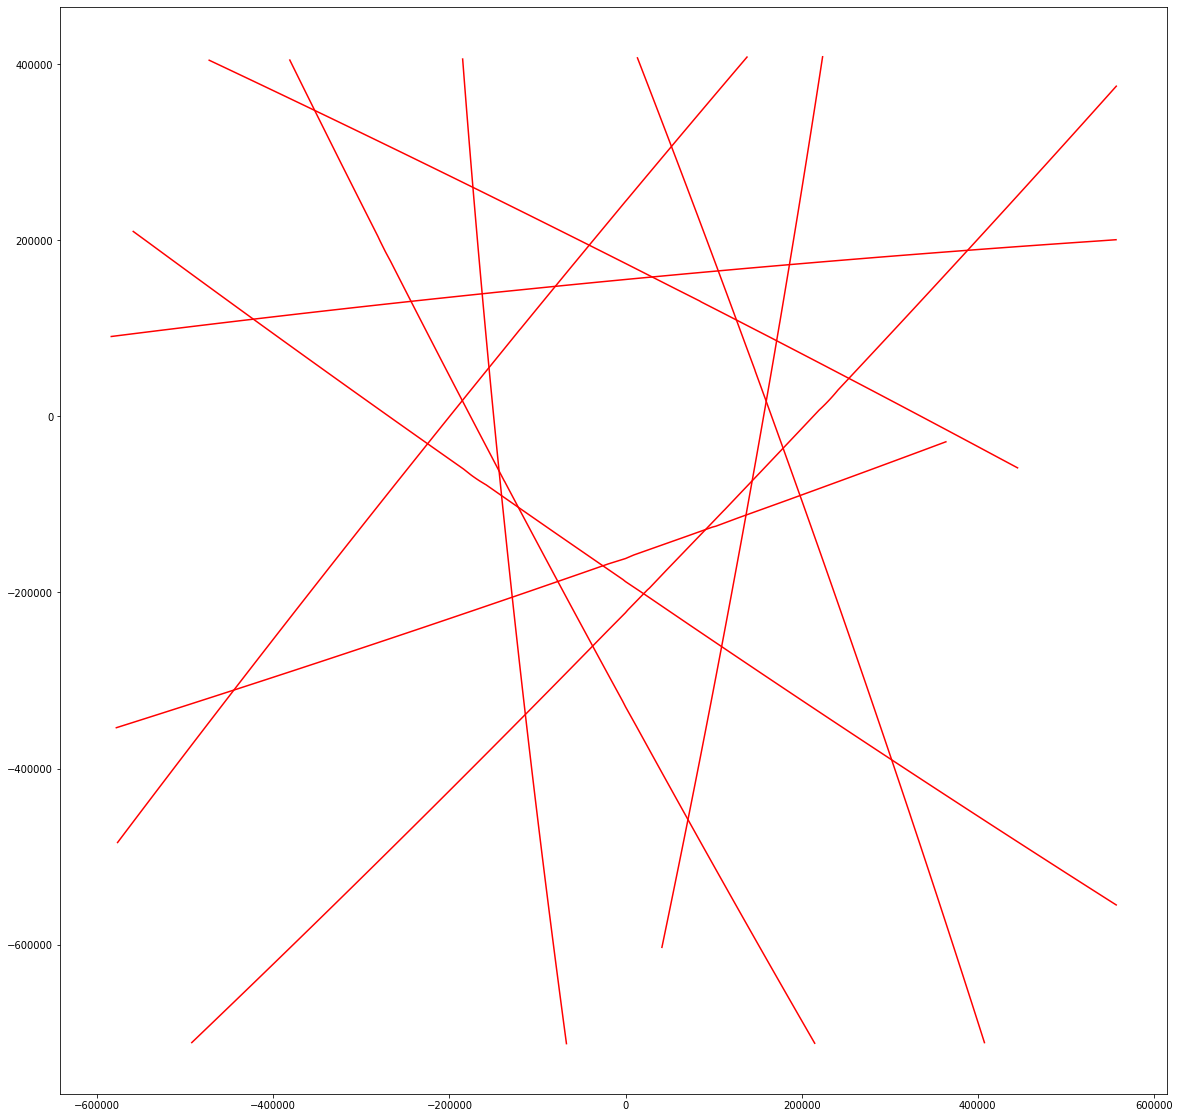

In [15]:
names = []
newselection = []
for i in range(len(secondsel)):
    names.append(secondsel[i].iloc[:,0].index)   #selects traks_id for each group
    newsel = random.choice(names[i])   #choose one random track for each group of tracks relative to each one of the points
    #better to find a more accurate criterion (ex: min distance from the point, track lenght)
    #maybe we could select more than one track for each group and see which one it's better for our analysis
    newselection.append(newsel)
#    sel.loc[names[i]].plot()
    
#a = secondsel[2]
#names = a.iloc[:,0].index

#sel.loc[names].plot(color='r')

print(newselection)
sel.loc[newselection].plot(color='r')